In [1]:
import re
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import regex as reg
import json
import unicodedata
%matplotlib inline

rootdir = '../data/papers/'

In [2]:
import unicodedata

# Reference Extraction:

In this notebook we explain how we can extract individual references from a section of references that are not uniformly separated. We do this by clever use of regular expressions and knowlegde of the format of references.

loading content of txt files that were previously extracted using the script:

In [3]:
contents = []
i = 0
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(unicodedata.normalize('NFC',text))
                    source.append(path[len(rootdir):-4])
                except:
                    name, message, content = sys.exc_info()
                    print(message)

## extracting the reference function from the text

One attempt was to use special splitting, in hopes that this would yield better results. We later saw that this was *not* helpful and thus ended up using other ways. The txt papers are not uniform, so we need to rely on more general knowledge of the structure of references, and can not just use smart white space splitting.

In [4]:
#Example of extraction
t = 'Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.\nAbrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),'
#split if \n comes after .
re.split(r'(?<=\.)\n', t)

['Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.',
 'Abrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),']

In [5]:
#dealing with links at the end
t =  'dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083\nEdelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning'
#similar regex with more condition
re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',t)

['dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083',
 None,
 None,
 'Edelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning']

The issue is that that above methods undersplit, so we it's better to just use \n, and than glue up separated sequences back together.

We first extract the part that contains references by finding the reference section, cutting off acknowledgements if the paper contains them, and then split up the reference part by lines:

In [6]:
reg.search('\n[\w]{2} (R|r)eferences\n', '\nrelevant scholary references\n')

In [7]:
def ref_extraction(text, extract=False):
    """extracts refrerence section: works well on well formated documents"""
    mention = text.rfind("\nReferences")
    if mention == -1:
        mention = text.rfind("\nReference")
    if mention == -1 and reg.search('\n[\p{L}]*( |)[\p{L}]*( |)(R|r)eferences\n', text):
        #to keep everything consistent substract
            mention =  reg.search('\n[\p{L}]*( |)[\p{L}]*( |)(R|r)eferences\n', text).span()[1] - len("references")
    if mention == -1:
        return None
    #get reference section, account for different spelling
    acknowledgements = max(text.find("Acknowledgement"), text.find('Acknowledgment'), text.find('Appendix'))
    
    #handle case that acknowlege ments are before references
    if acknowledgements < mention:
        acknowledgements = -1
    ref = text[mention+len("references"):acknowledgements]
    
    references = re.split(r'\n', ref)
    
    #extract references while not extracting bottom text 
    ref = [r for r in references if r and len(r) > 3 and not re.match(r'(CSCL|ICLS) \d{4} Proceedings|© ISLS', r)]
    if extract:
        print(text[mention+len("references"):acknowledgements])
        print(references)
    return ref

In [8]:
references = []
for i, content in enumerate(contents):
    references.append((ref_extraction(content)))

In [9]:
#remove pdfs that do not have 
reference_series = pd.DataFrame([references, source]).T.rename(columns={0: 'ref', 1: 'file'})
references = reference_series[reference_series.ref.notna()].ref.tolist()
source = reference_series[reference_series.ref.notna()].file.tolist()

In [10]:
reference_series[reference_series.ref.isna()]

,ref,file
262,None,2014_1691-1691
341,None,2016_98
376,None,2014_1698-1699
445,None,2014_1703-1703
562,None,2014_1697-1697
622,None,2016_136
626,None,2016_91
650,None,2016_93
702,None,2016_92
721,None,2016_96


In [11]:
print('Number of pdf documents : ', len(contents))
print('Number of documents for which we have an extracted reference section: ', len(references))

Number of pdf documents :  1125
Number of documents for which we have an extracted reference section:  1110


# Use Regex  to identify the what part of a reference a string is:

This is old code that was used at some point but is not no longer used. it identifies url or url like strings, which would belong to the reference above.

In [12]:
def match_url(sentence):
    return re.search('http(s)?\:\/\/[\S]*$', sentence) or re.search(r'doi\:[\S\/\*]*$', sentence)

def match_url_beginning(sentence):
    return re.search('^http(s)?\:\/\/[\S]*$', sentence) or re.search(r'^doi\:[\S\/\*]*$', sentence)

def show_issue(issues, condition):
    for issue in issues:
        if condition(issue):
            print(issue)

Central approach is to move sentences up until they are part of a string that contains a citation year, which usually is at the beginning of a string in an APA reference.


The references should start with a sequence of author names followed by a sequence in brackets identifying the year of publication. As sometimes the cited paper has not yet been published, a varitey of strings is used to indicate this status instead of the year. We add strings indicating this structure so we can identify a maximum of begining sequences, as they are important to get the entire reference.

In [13]:
def contains_citation_beginning(sentence):

    ##Check for mention of publication date,
    #do it this way to not allow for ICLS 2015 string to be counted
    months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
    publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}( |)[a-z]?[\,\ ]*'+months+'[\-\ \d]*'+months+'\)'
    
    #sometimes two years are mentioned, we use this regex to parse them
    match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    
    alternative_release = '|'.join(['in press', 'forthcoming', 'accepted', 'submitted', 'under review'])
    authors = '^[\p{L}\ \. \,\&\(\)\-\'\’\…]*'
    #these regex account for special strings used in the references
    match_press = authors + '('+alternative_release+')'
    sentence = sentence.lower()
        
    year = reg.match(authors + publication_year, sentence) or  reg.match(authors+match_bad_year, sentence)
    
    return  year or reg.match(match_press, sentence) 

In [14]:
contains_citation_beginning('Baker, R. S. J. d., D’Mello, S. K., Rodrigo, M. M. T., & Graesser, A. C. (2010). Better ')

<regex.Match object; span=(0, 79), match='baker, r. s. j. d., d’mello, s. k., rodrigo, m. m. t., & graesser, a. c. (2010)'>

In [15]:
alternative_release = '|'.join(['in press', 'forthcoming', 'accepted', 'submitted', 'under review'])
alternative_release

'in press|forthcoming|accepted|submitted|under review'

In [16]:
'('+alternative_release+')'

'(in press|forthcoming|accepted|submitted|under review)'

Example of the regexparsing working:

In [17]:
sentence = """Xing, W., Kim, S., & Goggins, S. (2015/1994). 
                Modeling performance in asynchronous CSCL: 
                an exploration of social ability, collective efficacy 
                and social interaction. Exploring the Material Conditions of Learning: 
                Proceedings of the Computer Supported Collaborative Learning (CSCL 2015), 
                International Society of"""

sentence_2 = """Engeström, Y. (1987/2014) Learning by expanding: 
                An activity-theoretical approach to developmental research (2nd ed.). 
                New York, NY: Cambridge University Press."""

months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ ]*'+months+'\)'


match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'

month = re.search(publication_year, sentence.lower())
conference =  re.search(match_bad_year, sentence_2)
    
conference, month

(<_sre.SRE_Match object; span=(14, 25), match='(1987/2014)'>, None)

The following function now implements this upwards or downwards of attaching a string to the previous one in a list of strings, if a given conditon is satisfied. 

For instace, One way we can know a line was split early is if it starts with lowercase letter or with a number.

In [18]:
reg.match('^[^\p{L}\*]|'+ #don't start with number or ., &
                                                    '(?!((d)[\p{Ll}])|(van))(^\p{Ll}{2,3} )|'+#no overly short non name start
                                                    '^\p{Ll}{6}[\p{Ll}]*|'+
                                                    '^([a-z]+[\.] )|'+ #no point
                                                    '^[\p{L}]*$', #no only word citations
                                                    'lollll ojfdfhb ')

<regex.Match object; span=(0, 6), match='lollll'>

In [19]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_up(issues, condition=lambda x: reg.match('^[^\p{L}\*]|'+ #don't start with number or ., &
                                                    '(?!((d)[\p{Ll}])|(van))(^\p{Ll}{2,3} )|'+#no overly short non name start
                                                    '^\p{Ll}{6}[\p{Ll}]*|'+
                                                    '^([a-z]+[\.] )|'+ #no point
                                                    '^[\p{L}]*$', #no only word citations
                                                    x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = []
    j = 0
    
    for i, sentence in enumerate(issues):
        if i != 0 and condition(sentence):
            patchwork[j-1] += ' ' + sentence
            #print(sentence)
        else:
            j +=1
            patchwork.append(sentence)
    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

Here we implement the inverse concept, of attaching a string to the next string in a list of strings if a condition is satisfied:

In [20]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_down(issues, condition=lambda x: re.match('^[\d\(\.]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = issues.copy()
    j = 0
    
    for i, sentence in enumerate(issues):
        if condition(sentence) and i+1 < len(issues):
            patchwork[i] = sentence + ' ' + patchwork[i+1]
            patchwork[i+1] = ''

    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

Here we have example sof the regex that will then be used, we should move a sequence up if name is cut off (for instance, sentence starts with C. ....)

In [21]:
cutoff_name = r'^[A-Z]+\.\ ?'
text = 'G. bsdjhvshjvf(1220)'
re.match(cutoff_name, text)

<_sre.SRE_Match object; span=(0, 3), match='G. '>

For references we might cut off the year from the authors. In that case we need to change strategy and move the one that is below up if the upper string satisfies the condition.

Here we have to other conditions that take care of potential issues such as having a word at the end or just a list of authors (and thus our way of identifying the beginning of a sentence will be not work)

In [22]:
def match_author(authors):
    regex = r'(([\p{L}\-]*[\,\&] [A-Z\.\ ]+[\&\,]?)*[\p{L}\ ]*$)'
    USA = r'([A-Z]{2,})'
    return not reg.search(USA, authors) and reg.match(regex, authors)


In [23]:
sentence = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'
match_author(sentence).group(0)

'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'

In [24]:
text = 'Walther, J. B., & Parks, M. R. (2002). Cues filtered out, cues filter in: computer mediated communication and'
words_at_end = r'( of| and| the| | [\p{Lu}])$'
reg.search(words_at_end, text)

<regex.Match object; span=(105, 109), match=' and'>

In [25]:
def contains_author(sentence):
    regex = r'(^[\p{L}\-\’\'\*]*[\,\&] [A-Z\.\ ]+[\&\,]?)'
    if reg.search(regex, sentence):
        return len(reg.search(regex, sentence).group(0)) > 0
    else:
        return False

In [26]:
#check if propper start
ref_1 = [moving_up(r, lambda x: re.match(cutoff_name, x)) for r in references]
ref_1 = [moving_down(r, lambda x: reg.search('In [\p{Lu}\-\.]*\.$|\:$|\,$', x)) for r in ref_1]

In [27]:
#make sure all authors listed by reference are are on one line
ref_1 = [moving_up(r) for r in ref_1]

ref_2 = [moving_down(r, match_author) for r in ref_1]
ref_2 = [moving_down(r, lambda x: reg.search(words_at_end, x)) for r in ref_2]

ref_3 = [moving_up(r, lambda x: not (contains_author(x) or contains_citation_beginning(x))) for r in ref_2]
#pivoting up around strings containing citation
ref_4 = [moving_up(r, lambda x: not contains_citation_beginning(x)) for r in ref_3]

Add the reference into dataframe, associating the source text to it:

In [28]:
references_df = pd.DataFrame([(f, source[i]) for i, flat in enumerate(ref_4) for f in flat], columns=['ref', 'file'])

In [29]:
references_df.sample(10).ref.tolist()

['Pea, R. (1993).Practices of distributed intelligence and designs for education. In G. Salomon (Ed.), Distributed Cognitions: Psychological and Educational Considerations, (pp. 47-87). Cambridge: Cambridge University Press.',
 'Kerosuo, H., & Engeström, Y. (2003). Boundary crossing and learning in creation of new work practice. Journal of Workplace Learning, 15, 345-351.',
 "Sandoval, W. A., & Morrison, K. (2003). High school students' ideas about theories and theory change after a biological inquiry unit. Journal of research in science teaching, 40(4), 369-392.",
 'Papert, S. (1980). Mindstorms: Children, computers, and powerful ideas. Basic Books, Inc.',
 'Kollar, I., Fischer, F., & Hesse, F. W. (2006). Collaboration scripts–a conceptual analysis. Educational Psychology Review, 18(2), 159-185.',
 'Hammer, D. (1989). Two approaches to learning physics. The Physics Teacher, 27(9), 664–670. doi:10.1119/1.2342910',
 'Batson, T. (2011). Situated learning: A theoretical frame to guide tra

In [30]:

source

['2018_14',
 '2016_39',
 '2018_28',
 '2018_297',
 '2018_283',
 '2016_11',
 '2018_268',
 '2018_254',
 '2018_240',
 '2018_526',
 '2016_149',
 '2014_1137-1141',
 '2014_278-285',
 '2016_161',
 '2014_1481-1482',
 '2016_175',
 '2017_6',
 '2017_51',
 '2014_471-478',
 '2014_527-534',
 '2017_45',
 '2017_79',
 '2017_92',
 '2017_86',
 '2014_1547-1548',
 '2018_485',
 '2018_491',
 '2014_863-870',
 '2014_1537-1538',
 '2018_308',
 '2018_446',
 '2014_729-736',
 '2018_320',
 '2018_334',
 '2018_452',
 '2014_972-976',
 '2018_335',
 '2015_302',
 '2018_453',
 '2018_447',
 '2018_321',
 '2018_309',
 '2015_1101',
 '2014_1406-1415',
 '2018_490',
 '2018_484',
 '2017_87',
 '2017_93',
 '2014_426-433',
 '2017_78',
 '2017_44',
 '2017_50',
 '2014_591-598',
 '2017_7',
 '2016_174',
 '2016_160',
 '2016_148',
 '2018_241',
 '2015_276',
 '2018_527',
 '2014_1509-1510',
 '2015_262',
 '2018_255',
 '2018_269',
 '2018_282',
 '2016_10',
 '2018_29',
 '2018_296',
 '2016_38',
 '2018_15',
 '2018_17',
 '2016_12',
 '2018_280',
 '2014

We use length and initial of the reference to preform a sanity check, by looking at initials (which should be upper case letters) and the total length of a reference.

In [31]:
references_df['length'] = references_df.ref.map(lambda x: len(x))
references_df['initial'] = references_df.ref.map(lambda x: x[0])

count    19114.000000
mean       184.896516
std        101.343273
min          4.000000
25%        137.000000
50%        177.000000
75%        218.000000
max      10209.000000
Name: length, dtype: float64

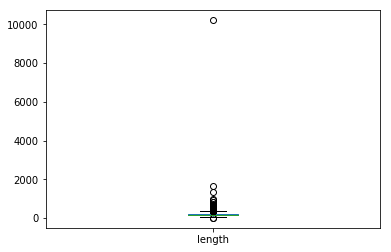

In [32]:
references_df.length.plot(kind='box')
references_df.length.describe()

In [33]:
references_df[references_df.length < 50]

,ref,file,length,initial
40,"Massey, D. (2005). For Space, London: Sage.",2016_39,43,M
150,OECD (2013). PISA 2012 Results. Paris: OECD.,2018_268,44,O
1719,"Transactions on, In press.",2015_1103,26,T
7731,"Massey, D. (2005). For space. Los Angeles: Sage.",2014_1436-1445,48,M
9496,"Wilensky, U. (1999). {NetLogo}.",2016_106,31,W
11170,"Spradley, J. P. (1980). Participant observation.",2018_215,48,S
11738,"Wilensky, U. (1999). {NetLogo}.",2018_1,31,W
12056,Learning (2013),2016_79,15,L
14710,1855,2018_513,4,1
14793,"Twenge, J. (2017). iGen. New York: Atria Books.",2018_507,47,T


In [34]:
references_df = references_df[references_df.length > 30]

No loss in the super short one, 1855 is from the previous page, and the only other invalid citation is The press reference. We do not need this part,

Inspecting the iverly long references, we see that they all come from papers that were not split up properly/do not match the metadata. Hence we can discard them without any loss.

In [35]:
references_df[references_df.length > 600].file.drop_duplicates()

1005         2018_269
1740         2018_323
3727         2018_523
3966     2014_246-253
4194        2015_1110
4878     2014_487-494
7871     2014_551-558
8885          2017_37
12483        2015_192
14370        2016_127
15870        2018_276
16194        2015_335
16850         2016_22
18267        2016_145
19007         2016_34
Name: file, dtype: object

Bad citing: import2015full_335, import2015short_192, import2016full_34, import2017_35, import2018_269, import2018_323, import2015short_1110

Again, invalid citation is either from invalid file (import2016short_145) or actually valid but long citation

We now chech the initial: We see that the method seems to work for most references, and that some references start with lower case letters, mostly due to different conventions between name writing, thing the dutch 'van'

In [36]:
r = references_df[references_df.initial.isin(references_df.initial.value_counts().tail(5).index)]
r#[~r.file.duplicated()]

,ref,file,length,initial
2463,"Åberg, M., Mäkitalo, Å., & Säljö, R. (2010). K...",2016_173,265,Å
12481,* References marked with an asterisk indicate ...,2015_192,380,*
15014,"Ødegaard, M. (2003). Dramatic science. A criti...",2018_466,129,Ø
15158,"Žavbi, R., & Tavčar, J. (2005). Preparing unde...",2017_59,150,Ž
15644,edTPA. (2015). About edTPA: Overview. Retrieve...,2016_19,87,e


non APA citations: import2018_523

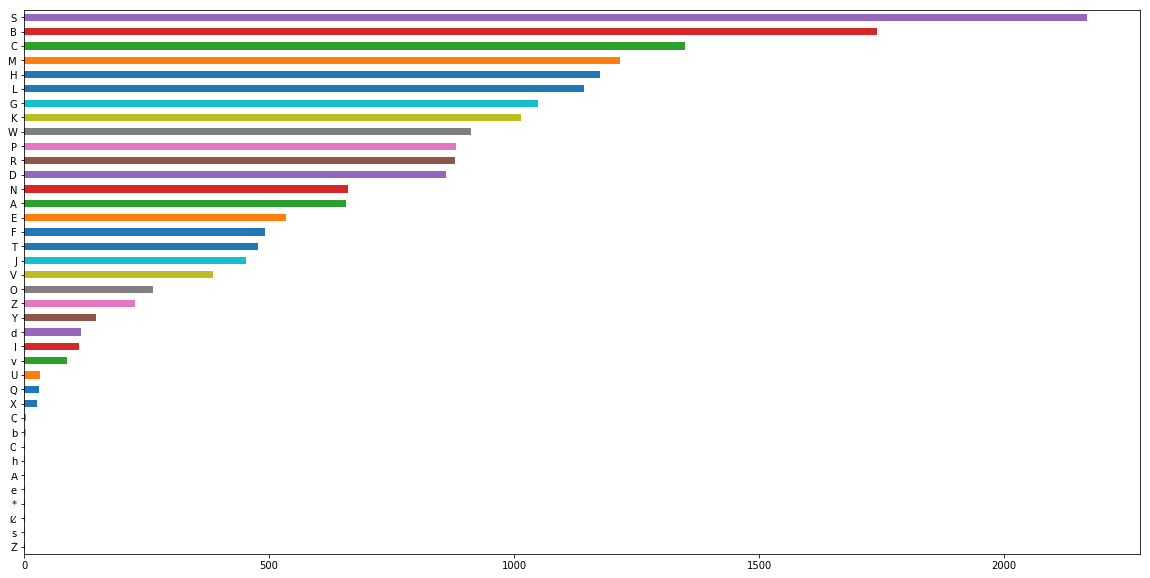

In [37]:
plt.figure(figsize=(20, 10))
references_df.initial.value_counts().sort_values(ascending=True).plot(kind='barh')

In [38]:
#also correctly parsed i, e are fine, a are not too bad, leave it
#only very few references are incorrect if they start by lowercase. we accept this
#b is correct
references_df[references_df['initial'] == 'b']

,ref,file,length,initial
11047,"boyd, D. (2007). Why youth (heart) social netw...",2014_455-462,243,b
11655,"boyd, d. (2014). It’s complicated: The social ...",2018_176,109,b
19095,"boyd, d. (2009). Why Youth (Heart) Social Netw...",2015_285,110,b


Remove overly long references are they are due to badly parsed pdfs:

In [39]:
references_df = references_df[(references_df.length < 800)]

In [40]:
print('We can parse references from {} documents.'.format(references_df.file.value_counts().shape[0]))

We can parse references from 1109 documents.


Example reference, where we can see that our parsing method works quite well:

In [41]:
references_df[references_df.length < 200].sample(5).ref.tolist()

['Clark, H. H. (1996). Using Language. Cambridge, UK: Cambridge University Press.',
 'Pomerantz, A., & Fehr, B. J. (1997). Conversation analysis: An approach to the study of social action as sense making practices. Discourse as Social Interaction, 2, 64-91.',
 'Posner, G., & Rudnitsky, A. (2005). Course design: A guide to curriculum development for teachers (7th ed.): Allyn & Bacon.',
 'Sweller, J., van Merrienboer, J. J., & Paas, F. G. (1998). Cognitive architecture and instructional design. Educational Psychology Review, 10(3), 251-296.',
 'Missildine, K., Fountain, R., Summers, L., & Gosselin, K. (2013). Flipping the classroom to improve student performance and satisfaction. The Journal of Nursing Education, 52(10), 597-599.']

# Approach to get author names from references:

For APA style it is easy to extract the year and author of the cited reference, as we know that all authors are listed before (some time reference) Hence we extract the section before "some time reference" and then use the special way that a list of authors is cited in APA style to split up the authors:

In [42]:
def get_authors(sentence, debug = False):
    regex = r'[\S\s]*\((18|19|20)\d{2}[\,\ \w\d]*\)'
    if re.search(regex, sentence):
        s = re.findall(regex, sentence)[0]
        if len(s) > 9:
            return (s)
    elif debug:
        return '#'+sentence
    
    return np.nan


def get_authors_month(sentence, debug = False):
    
    #make sure sentence is encoded in the same way:
    sentence = unicodedata.normalize('NFC', sentence)
    regex = r'[\p{L}\,\ \.\:\;\/\&\-\'\`\(\)\’\–\¨\…\‐\*\´\＆\\]*\([\,\ \p{L}\d\-]*(18|19|20)\d{2}[\,\ \p{L}\d\-]*\)'
    match_bad_year = r'[\S\s]*\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    match_press = r'[\S\s]*\((i|I)n (P|p)ress|manuscript under review\)'
    match_forth = r'[\S\s]*\((f|F)orthcoming\)'
    match_accepted = r'[\S\s]*\((a|A)ccepted\)'
    match_submitted = r'[\S\s]*\((s|S)ubmitted\)'
    match_underreview = r'[\S\s]*\((u|U)nder (R|r)eview\)'
    
    #sentence = sentence.lower()
    if reg.match(regex, sentence):
        s = reg.search(regex, sentence).group(0)
        if len(s) > 9:
            return s
    elif re.match(match_bad_year, sentence):
        return re.search(match_bad_year, sentence).group(0)
    elif re.match(match_press, sentence):
        return re.search(match_press, sentence).group(0)
    elif re.match(match_forth, sentence):
        return re.search(match_forth, sentence).group(0)
    elif re.match(match_accepted, sentence):
        return re.search(match_accepted, sentence).group(0)
    elif re.match(match_submitted, sentence):
        return re.search(match_submitted, sentence).group(0)
    elif re.match(match_underreview, sentence):
        return re.search(match_underreview, sentence).group(0)
    
    return np.nan

Extract authors and month:

In [43]:
references_df['ref_parsed'] = references_df.apply(lambda x: get_authors_month(x['ref']), axis=1)

In [44]:
print('Percentage of unparsed references: {:0.2f}'.format(references_df.ref_parsed.isna().sum()/references_df.ref_parsed.shape[0]))
print('Number of unparsed references: ', references_df[references_df.ref_parsed.isna()].ref.shape[0])
print('Number of properly parsed references: ', references_df.ref_parsed.shape[0])

Percentage of unparsed references: 0.00
Number of unparsed references:  25
Number of properly parsed references:  19104


Taking a look at the unparsed files, we see that many references that could not be parsed are form manuals, or not cited propperly. We do not care about these and can thus discard them.

In [45]:
references_df[references_df.ref_parsed.isna()].ref.tolist()  

['Malmberg, J., et al. (re-submitted). Promoting socially shared regulation of learning in CSCL: Progress of socially shared regulation among high- and low-performing groups. Computers in Human Behavior.',
 'Activities. Journal of the Learning Sciences, (just-accepted).',
 'Education. Submitted to International Journal of Science Education.',
 'Accessible Rich Internet Applications (WAI-ARIA) 1.1. (2016, July 21). Retrieved October 26, 2016, from https://www.w3.org/TR/wai-aria-1.1/',
 'Shayan Doroudi and Emma Brunskill. The misidentified identifiability problem of Bayesian Knowledge Tracing. In Educational Data Mining, pages 143–149. International Educational Data Mining Society, 2017. Shayan Doroudi, Ece Kamar, Emma Brunskill, and Eric Horvitz. Toward a learning science for complex crowdsourcing tasks. In Proceedings of the 2016 CHI Conference on Human Factors in Computing Systems, pages 2623–2634. ACM, 2016. Shayan Doroudi, Vincent Aleven, and Emma Brunskill. Robust Evaluation Matrix

Taking a peek at how the dataframe currently looks like:

In [46]:
references_df.head()

,ref,file,length,initial,ref_parsed
0,"Benner, A. D., & Mistry, R. S. (2007). Congrue...",2018_14,190,B,"Benner, A. D., & Mistry, R. S. (2007)"
1,"Cheryan, S., Siy, J. O., Vichayapai, M., Drury...",2018_14,236,C,"Cheryan, S., Siy, J. O., Vichayapai, M., Drury..."
2,"Clance, P. R., & Imes, S. A. (1978). The impos...",2018_14,180,C,"Clance, P. R., & Imes, S. A. (1978)"
3,"Cole, M. (1996). Cultural psychology: A once a...",2018_14,91,C,"Cole, M. (1996)"
4,"Cooper, H. M., Findley, M., and Good, T. (1982...",2018_14,182,C,"Cooper, H. M., Findley, M., and Good, T. (1982)"


# Extracting year of individual references:
### Extracting the year of publication:

Again we can use the structure of apa citations to extract the year of the citation, in case of 'in press' we just set the year to the year of the file:

In [47]:
def extract_year(x, current_year):
    match_press = r'\(in press|submitted|under review|accepted|forthcoming'
    years = r'\([\w\d\,\ \.\-]*(18|19|20)\d{2}[\,\ \w\d\/\-]*\)'
    year = re.search(years, x)
    if re.search(match_press, x.lower()):
        return current_year
    if year:
        year = year.group(0)
        year = re.findall('\d{4}', year)
        return int(year[0])
    else:
        return np.nan

In [48]:
references_df.head()

,ref,file,length,initial,ref_parsed
0,"Benner, A. D., & Mistry, R. S. (2007). Congrue...",2018_14,190,B,"Benner, A. D., & Mistry, R. S. (2007)"
1,"Cheryan, S., Siy, J. O., Vichayapai, M., Drury...",2018_14,236,C,"Cheryan, S., Siy, J. O., Vichayapai, M., Drury..."
2,"Clance, P. R., & Imes, S. A. (1978). The impos...",2018_14,180,C,"Clance, P. R., & Imes, S. A. (1978)"
3,"Cole, M. (1996). Cultural psychology: A once a...",2018_14,91,C,"Cole, M. (1996)"
4,"Cooper, H. M., Findley, M., and Good, T. (1982...",2018_14,182,C,"Cooper, H. M., Findley, M., and Good, T. (1982)"


In [49]:
references_df.file.map(lambda x: int(re.search('20[\d]{2}', x).group(0)))

0        2018
1        2018
2        2018
3        2018
4        2018
5        2018
6        2018
7        2018
8        2018
9        2018
10       2018
11       2018
12       2018
13       2018
14       2018
15       2018
16       2018
17       2018
18       2018
19       2018
20       2018
21       2018
22       2018
23       2018
24       2018
25       2018
26       2018
27       2018
28       2018
29       2018
         ... 
19084    2016
19085    2016
19086    2016
19087    2016
19088    2016
19089    2016
19090    2014
19091    2014
19092    2014
19093    2015
19094    2015
19095    2015
19096    2015
19097    2015
19098    2015
19099    2015
19100    2015
19101    2015
19102    2015
19103    2015
19104    2015
19105    2015
19106    2015
19107    2015
19108    2015
19109    2015
19110    2015
19111    2015
19112    2015
19113    2015
Name: file, Length: 19104, dtype: int64

In [50]:
references_df['pub_year'] = references_df.file.map(lambda x: int(re.search('20[\d]{2}', x).group(0)))

In [51]:
references_df.loc[~references_df.ref_parsed.isna(),'year'] = references_df[~references_df.ref_parsed.isna()].apply(
    lambda x: extract_year(x.ref_parsed, x.pub_year), axis=1)

In [52]:
references_df[references_df.year.isna() & references_df.ref_parsed.notna()].shape

(0, 7)

In [53]:
references_df[references_df.year.isna() & references_df.ref_parsed.notna()].ref_parsed.tolist()

[]

## Look at extracting individual  author names:

For now we look only the the authors that come up in any citation in the paper. So we do not care about order or the specific reference they are associated with:

We again use a regex to extract neighbours, but in the end we use the approach of spliting up the file after a ., or an and or & or ;

In [54]:
authors = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D., Scheintaub, H., Klopfer, E.'

re.findall(r'([A-Z][^\W\d_\-]*\,?\&? [A-Z]\.\,?)', authors)

['Yoon, S.,',
 'Anderson, E.,',
 'Evans, C.,',
 'Park, M.,',
 'Sheldon, J.,',
 'Schoenfeld, I.,',
 'Wendel, D.,',
 'Scheintaub, H.,',
 'Klopfer, E.']

In [55]:
regex = r'([\w\-]*[\,] [A-Z\.\ ]+[\&\,]?)'

In [56]:
#extract authors and clean strings a bit
author_split = r'([\p{L}\-]*[\,] [\p{L}\.\ \-]*[\&\,\.]?)'
author_split_2 = r'([\p{L}\-\.\ ]* [\p{L}\. \ \-]*[\,\.]?)'

reg.findall(author_split_2, 'Selwyn N. (2007)')

['Selwyn N. ']

This function implements the searching for individual authors:

In [57]:
def extract_author(x):
    author_split = r'\.\,| & | and |;'
    list_authors = reg.split(author_split, x)
    list_authors = [name.replace('&', '').replace(',', '').strip() for name in list_authors]
    #remove end of string that isn't name
    list_authors = [re.sub(r'\([\s\S]*\)|\.\.\.|…| et al.|\.', '', name).strip() for name in list_authors if len(name) > 0]
    list_authors = [name for name in list_authors if len(name) > 0]
    return list_authors

We get the individual authors and then change the structure of the dataframe to have one author column containing a single author.

In [58]:
references_df['authors'] =  references_df[~references_df.ref_parsed.isna()].ref_parsed.map(lambda x: extract_author(x))

#go from a list of authors to on author per row

tags = references_df.authors.apply(pd.Series)
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

df = pd.concat([references_df, tags], axis=1)
tag_cols = [c for c in df.columns if 'tag' not in c]
df = df.melt(id_vars=tag_cols)

df['author'] = df['value']
df = df[df.value.notna()].reset_index(drop=True)
del df['variable'], df['authors'], df['value']

We now check the result we get sofar:

In [59]:
df.author.head(20)

0                                            Benner A D
1                                             Cheryan S
2                                            Clance P R
3                                                Cole M
4                                            Cooper H M
5                                           Correll S J
6                                             de Fina A
7                                           Diamond J B
8                                               Deaux K
9                                          Espinosa L L
10                                         Griffith A L
11                                         Herrmann S D
12                                           Hinojosa L
13                                           Hinojosa L
14                                            MacPhee D
15                                             Marx D M
16                                            Meece J L
17    National Science Foundation National Cente

This seems to work quite well, but lets check the short names to in case we have outliers:

We see that there are some issues, but overall not that many

In [60]:
df[df.author.map(lambda x: len(x) < 2)].author.value_counts()

L    4
M    4
A    3
K    3
J    3
W    2
C    1
Z    1
D    1
Name: author, dtype: int64

Here we see that the issues are to to irregular listing of names. It makes sense that we have issues extracting these strings:

In [61]:
s = df[df.author.map(lambda x: len(x) < 2)].sample(5)

s.ref_parsed.tolist()

['Borko, H., Stecher, B., M., Alonzo, A. C., Moncure, S., and McClam, S. (2005)',
 'Leijen, Ä., Lam, I., Wildschut., L., & Simons, R. (2009)',
 'Andriessen, J., Baker, M. & van der Puil., C. (2011)',
 'Reiser, B., J. (2013)',
 'Holland, D., Lachicotte Jr., W., Skinner, D., & Cain, C. (1998)']

In [62]:
s.author.tolist()

['M', 'L', 'C', 'J', 'W']

In [63]:
df[df.author == 'M. Chui B. Brown J. Bughin R. Dobbs C. Roxburgh et al.'].ref_parsed.tolist()

[]

In [64]:
extract_author('Manyika, J., M. Chui, B. Brown, J. Bughin, R. Dobbs, C. Roxburgh, et al. (2011)')

['Manyika J', 'M Chui B Brown J Bughin R Dobbs C Roxburgh']

When we look at the extra logn names, we ca also see that the extaction works reasonably well:

(again bearing in mind that some people do not follow the conventions, but there are so few of them that we will exclude them)

In [65]:
df[df.author.map(lambda x: len(x) > 30)].author.value_counts()

Design-Based Research Collective                                                                                10
The Design-Based Research Collective                                                                             9
National Center for Education Statistics                                                                         6
National Governors Association Center for Best Practices                                                         5
National Academies of Sciences Engineering                                                                       5
National Academy of Engineering                                                                                  5
National Council of Teachers of Mathematics                                                                      5
Common Core State Standards Initiative                                                                           4
American Psychological Association                                              

In [66]:
df

,ref,file,length,initial,ref_parsed,pub_year,year,author
0,"Benner, A. D., & Mistry, R. S. (2007). Congrue...",2018_14,190,B,"Benner, A. D., & Mistry, R. S. (2007)",2018,2007.0,Benner A D
1,"Cheryan, S., Siy, J. O., Vichayapai, M., Drury...",2018_14,236,C,"Cheryan, S., Siy, J. O., Vichayapai, M., Drury...",2018,2011.0,Cheryan S
2,"Clance, P. R., & Imes, S. A. (1978). The impos...",2018_14,180,C,"Clance, P. R., & Imes, S. A. (1978)",2018,1978.0,Clance P R
3,"Cole, M. (1996). Cultural psychology: A once a...",2018_14,91,C,"Cole, M. (1996)",2018,1996.0,Cole M
4,"Cooper, H. M., Findley, M., and Good, T. (1982...",2018_14,182,C,"Cooper, H. M., Findley, M., and Good, T. (1982)",2018,1982.0,Cooper H M
5,"Correll, S. J. (2001). Gender and the Career C...",2018_14,148,C,"Correll, S. J. (2001)",2018,2001.0,Correll S J
6,"de Fina, A. (2015). Narrative and identities. ...",2018_14,164,d,"de Fina, A. (2015)",2018,2015.0,de Fina A
7,"Diamond, J. B., Randolph, A. & Spillane, J. P....",2018_14,262,D,"Diamond, J. B., Randolph, A. & Spillane, J. P....",2018,2004.0,Diamond J B
8,"Deaux, K., & Emswiller, T. (1974). Explanation...",2018_14,202,D,"Deaux, K., & Emswiller, T. (1974)",2018,1974.0,Deaux K
9,"Espinosa, L. L. (2011). Pipelines and pathways...",2018_14,199,E,"Espinosa, L. L. (2011)",2018,2011.0,Espinosa L L


# Using scholarcy  

In [67]:
import requests

In [68]:
import os

In [69]:
for subdir, dirs, files in os.walk('../papers-import/'):
    for file in files:
        if file[-4:] == '.pdf' and not file [:-4]+'.xml' in files:
            print(subdir+'/'+file)

../papers-import/2014/440-447/440-447.pdf
../papers-import/2014/527-534/527-534.pdf
../papers-import/2014/1117-1121/1117-1121.pdf
../papers-import/2014/394-401/394-401.pdf
../papers-import/2014/46-53/46-53.pdf
../papers-import/2014/1529-1530/1529-1530.pdf
../papers-import/2014/1621-1622/1621-1622.pdf
../papers-import/2014/206-213/206-213.pdf
../papers-import/2014/681-688/681-688.pdf
../papers-import/2014/1499-1500/1499-1500.pdf
../papers-import/2014/1042-1046/1042-1046.pdf
../papers-import/2014/1655-1656/1655-1656.pdf
../papers-import/2014/625-632/625-632.pdf
../papers-import/2014/769-776/769-776.pdf
../papers-import/2014/1147-1151/1147-1151.pdf
../papers-import/2014/1505-1506/1505-1506.pdf
../papers-import/2014/1571-1572/1571-1572.pdf
../papers-import/2014/1692-1696/1692-1696.pdf
../papers-import/2014/1342-1351/1342-1351.pdf
../papers-import/2014/1659-1660/1659-1660.pdf
../papers-import/2014/1057-1061/1057-1061.pdf
../papers-import/2014/1651-1652/1651-1652.pdf
../papers-import/2014/97

../papers-import/2018/492/492.pdf
../papers-import/2018/264/264.pdf
../papers-import/2018/432/432.pdf
../papers-import/2018/290/290.pdf
../papers-import/2018/297/297.pdf
../papers-import/2018/435/435.pdf
../papers-import/2018/263/263.pdf
../papers-import/2018/255/255.pdf
../papers-import/2018/403/403.pdf
../papers-import/2018/404/404.pdf
../papers-import/2018/252/252.pdf
../papers-import/2018/299/299.pdf
../papers-import/2018/46/46.pdf
../papers-import/2018/79/79.pdf
../papers-import/2018/320/320.pdf
../papers-import/2018/318/318.pdf
../papers-import/2018/41/41.pdf
../papers-import/2018/327/327.pdf
../papers-import/2018/77/77.pdf
../papers-import/2018/311/311.pdf
../papers-import/2018/48/48.pdf
../papers-import/2018/70/70.pdf
../papers-import/2018/329/329.pdf
../papers-import/2018/316/316.pdf
../papers-import/2018/184/184.pdf
../papers-import/2018/514/514.pdf
../papers-import/2018/342/342.pdf
../papers-import/2018/170/170.pdf
../papers-import/2018/24/24.pdf
../papers-import/2018/389/38

In [70]:
for subdir, dirs, files in sorted(os.walk('../papers-import/')):
    for file in files:
        if file[-4:] == '.pdf' and not file [:-4]+'.xml' in files:
            print(subdir+'/'+file)

            destination = source[:-4]+'.xml'

            headers = {
                'accept': 'application/json',
            }
#             print('1')
            files_ = {
                'reference_format': (None, 'xml'),
                'file': (open(source, 'rb')),
                'document_type': (None, 'full_paper'),
                'reference_style': (None, 'apa'),
            }
            print(files)
            response = requests.post('https://ref.scholarcy.com/api/references/download', headers=headers, files=files_)
            if response.ok:
                print('y')
#                 with open(destination, 'w') as f:
#                     f.write(response.text)
            else:
                print('Nope')

../papers-import/2014/1002-1006/1002-1006.pdf


TypeError: can only concatenate list (not "str") to list

In [ ]:
source = '../papers-import/import2015full/105/105.pdf'

destination = source[:-4]+'.xml'

headers = {
    'accept': 'application/json',
    'Authorization': 'Bearer',
}

files = {
    'reference_format': (None, 'xml'),
    'file': (open(source, 'rb')),
    'document_type': (None, 'full_paper'),
    'reference_style': (None, 'apa'),
}

response = requests.post('https://ref.scholarcy.com/api/references/download', headers=headers, files=files)

with open(destination, 'w') as f:
    f.write(response.text)

In [ ]:
response.content

In [ ]:
from lxml import etree

In [ ]:
xml2 = etree.iterparse(destination, recover=True)
data = []
for action, elem in xml2:
    data.append((elem.attrib, elem.tag, elem.text))

In [ ]:
data

For an analysis of this dataset check the Dataexploration - References notebook